In [17]:
# Importing libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # for visualization purposes
import seaborn as sns # for visualization purposes
import statsmodels as sm # for intercept
from statsmodels.stats.outliers_influence import variance_inflation_factor  # we will need vif for checking multicollinearity
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV  # for data splitting and parameter tuning
from sklearn.pipeline import Pipeline # used when scaling data to avoid data leaks (used with LR)
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # linear regression models
from sklearn.preprocessing import StandardScaler # for creating scaled data for linear regression
from sklearn.metrics import r2_score,mean_squared_error   # for scoring the model and calculating the mean squared error
from sklearn.tree import DecisionTreeRegressor  # decision tree regression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor  # ensemble methods for regression
from sklearn.model_selection import cross_val_score # for cross-validation
from xgboost import XGBRegressor # XGB Regressor

import warnings
warnings.filterwarnings('ignore')

## Data import

In [2]:
# Load data from the repository
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', sep="\\s+", header=None)

# Rename columns according to 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names'
data.columns = ['mpg', 'cylinders', 'displacement', 'horsepower' , 'weight', 'acceleration', 'model year', 'origin', 'car']

# Initial glance over data
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Data cleaning

### Checking for variable types and missing values

In [3]:
# Information about variable types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car           398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [4]:
# There must be a reason why column horsepower is object when in reality should be float64 (number)
# so we use .unique to display unique values and check for oddities
data.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [5]:
# The odd value is "?" which represents a null value and we can substitute it for a mean horsepower
data.horsepower = data.horsepower.str.replace('?','NaN').astype(float) # this replaces '?' with nan
data.horsepower.fillna(data.horsepower.mean(), inplace=True) # this replaces all nan values with mean

# to simplify, make the column int type
data.horsepower = data.horsepower.astype(int)

/var/folders/_d/1b2bwsj97vl8l973k2_204tc0000gn/T/ipykernel_69991/1284821340.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.horsepower.fillna(data.horsepower.mean(), inplace=True) # this replaces all nan values with mean


### Checking for duplicate values

In [6]:
# Information about duplicate values
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


### Checking for zero values

In [7]:
print((data == 0).sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car             0
dtype: int64


### Checking for outliers and inconsistencies

In [8]:
display(data.describe())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.462312,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.199230,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## Visual inspection

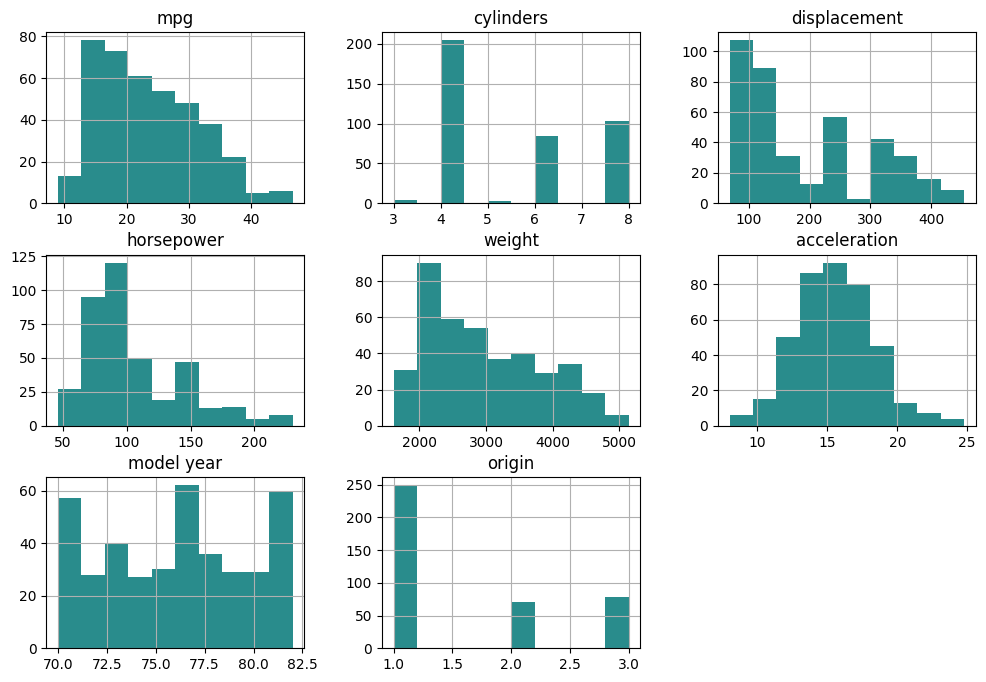

In [9]:
# First drop variable car
data1 = data.drop(['car'], axis=1)

# Visually inspect variables
data1.hist(figsize=(12, 8), color='#298c8c')
plt.show()

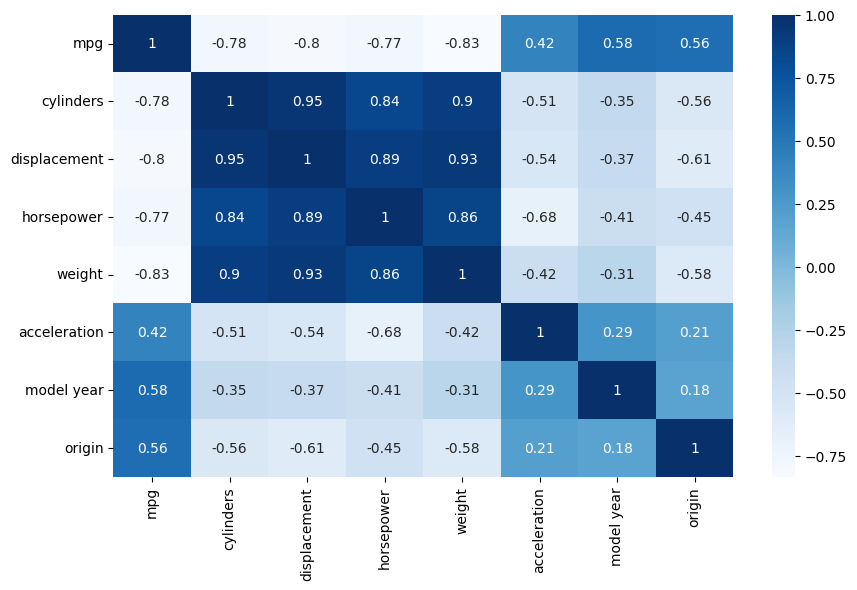

In [10]:
# Explore relationships between variables visually (correlation matrix)
plt.figure(figsize=(10,6))
sns.heatmap(data1.corr(),cmap=plt.cm.Blues,annot=True) # use seaborn
plt.show()

In [11]:
# Cylinders, Displacement, Horsepower and Weight are all highly (negatively) correlated so we have multicollinearity issue
# Calculate variance inflation factor (VIF) for each variable to determine which one to keep
X1 = sm.tools.add_constant(data1) # add intercept to the dataset 
# Calculate VIF for the dataset
vif1 = pd.Series([variance_inflation_factor(X1.values,i)
                     for i in range(X1.shape[1])], index=X1.columns)
vif1

const           780.811358
mpg               5.583594
cylinders        10.742336
displacement     22.159830
horsepower        9.056781
weight           13.468785
acceleration      2.515908
model year        1.954947
origin            1.853326
dtype: float64

In [12]:
# Highest VIF is Displacement so remove all variables with VIF above 10 and check again
data2 = data1.drop(['cylinders', 'displacement', 'weight'],axis=1)

# Calculate VIF again after removing Displacement
X2 = sm.tools.add_constant(data2)
vif2 = pd.Series([variance_inflation_factor(X2.values,i) 
                     for i in range(X2.shape[1])], index=X2.columns)
vif2

const           715.683761
mpg               3.982206
horsepower        4.131289
acceleration      2.029527
model year        1.607080
origin            1.542532
dtype: float64

#### All looks good and none of the variables' VIF is above 5 so other variables are all included in the model

## Predictive modeling

### Split the dataset into training and testing data

In [13]:
# Divide data into independent and dependent data (X, y)
X = data2.drop('mpg',axis=1)  # create a DF of independent variables (without a dependent variable)
y = data2.mpg   # create a series of the dependent variable

# split the data into training and testing data (80-20 split)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Fit regression models

In [14]:
# Linear Regression
model_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
model_1.fit(X_train, y_train)

# Checking if model 1 is over or underfitted
m1_train_pred = model_1.predict(X_train)
m1_test_pred = model_1.predict(X_test)
# R2 Scores
m1_train_r2 = r2_score(y_train, m1_train_pred)
m1_test_r2 = r2_score(y_test, m1_test_pred)
# MSE
m1_train_mse = mean_squared_error(y_train, m1_train_pred)
m1_test_mse = mean_squared_error(y_test, m1_test_pred)
# Cross-validation
cv_scores1 = cross_val_score(model_1, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 1: Linear Regression')
print(' Train R2 : {:.4f}'.format(m1_train_r2))
print(' Test  R2 : {:.4f}'.format(m1_test_r2))
print(' Train MSE: {:.4f}'.format(m1_train_mse))
print(' Test  MSE: {:.4f}'.format(m1_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores1.mean(), cv_scores1.std()))


# Ridge
d2 = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
params = {'ridge__alpha': [0, 0.1, 0.01, 0.001, 1]}
model_2 = GridSearchCV(d2, params, cv=5, n_jobs=-1)
model_2.fit(X_train,y_train)

# Checking if model 2 is over or underfitted
m2_train_pred = model_2.predict(X_train)
m2_test_pred = model_2.predict(X_test)
# R2 Scores
m2_train_r2 = r2_score(y_train, m2_train_pred)
m2_test_r2 = r2_score(y_test, m2_test_pred)
# MSE
m2_train_mse = mean_squared_error(y_train, m2_train_pred)
m2_test_mse = mean_squared_error(y_test, m2_test_pred)
# Cross-validation
cv_scores2 = cross_val_score(model_2, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 2: Ridge')
print(' Train R2 : {:.4f}'.format(m2_train_r2))
print(' Test  R2 : {:.4f}'.format(m2_test_r2))
print(' Train MSE: {:.4f}'.format(m2_train_mse))
print(' Test  MSE: {:.4f}'.format(m2_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores2.mean(), cv_scores2.std()))


# Lasso
d3 = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())])
params = {'lasso__alpha':[0.1,0.01,0.001,1],
          'lasso__max_iter':[1000,10000,100000,1000000]}
model_3 = GridSearchCV(d3, params, cv=5, n_jobs=-1)
model_3.fit(X_train,y_train)

# Checking if model 2 is over or underfitted
m3_train_pred = model_3.predict(X_train)
m3_test_pred = model_3.predict(X_test)
# R2 Scores
m3_train_r2 = r2_score(y_train, m3_train_pred)
m3_test_r2 = r2_score(y_test, m3_test_pred)
# MSE
m3_train_mse = mean_squared_error(y_train, m3_train_pred)
m3_test_mse = mean_squared_error(y_test, m3_test_pred)
# Cross-validation
cv_scores3 = cross_val_score(model_3, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 3: Lasso')
print(' Train R2 : {:.4f}'.format(m3_train_r2))
print(' Test  R2 : {:.4f}'.format(m3_test_r2))
print(' Train MSE: {:.4f}'.format(m3_train_mse))
print(' Test  MSE: {:.4f}'.format(m3_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores3.mean(), cv_scores3.std()))


# DTR
dtr = DecisionTreeRegressor(random_state=42)
params = {'max_features':[None,'sqrt','log2'],
          'min_samples_split':range(2, 10),
          'min_samples_leaf':range(1, 10),
          'max_depth':range(2, 10)} 
model_4 = RandomizedSearchCV(dtr, params, cv=5, n_jobs=-1)
model_4.fit(X_train,y_train)

# Checking if model 4 is over or underfitted
m4_train_pred = model_4.predict(X_train)
m4_test_pred = model_4.predict(X_test)
# R2 Scores
m4_train_r2 = r2_score(y_train, m4_train_pred)
m4_test_r2 = r2_score(y_test, m4_test_pred)
# MSE
m4_train_mse = mean_squared_error(y_train, m4_train_pred)
m4_test_mse = mean_squared_error(y_test, m4_test_pred)
# Cross-validation
cv_scores4 = cross_val_score(model_4.best_estimator_, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 4: Decision Tree Regressor')
print(' Train R2 : {:.4f}'.format(m4_train_r2))
print(' Test  R2 : {:.4f}'.format(m4_test_r2))
print(' Train MSE: {:.4f}'.format(m4_train_mse))
print(' Test  MSE: {:.4f}'.format(m4_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores4.mean(), cv_scores4.std()))


# RFR
rfr = RandomForestRegressor(random_state=42)
params = {
    'n_estimators': [100,200,300,400,500],
    'max_depth': range(2, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2']
}
model_5 = RandomizedSearchCV(rfr, params, cv=5, n_jobs=-1, n_iter=50, random_state=42)
model_5.fit(X_train,y_train)

# Checking if model 5 is over or underfitted
m5_train_pred = model_5.predict(X_train)
m5_test_pred = model_5.predict(X_test)
# R2 Scores
m5_train_r2 = r2_score(y_train, m5_train_pred)
m5_test_r2 = r2_score(y_test, m5_test_pred)
# MSE
m5_train_mse = mean_squared_error(y_train, m5_train_pred)
m5_test_mse = mean_squared_error(y_test, m5_test_pred)
# Cross-validation
cv_scores5 = cross_val_score(model_5.best_estimator_, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 5: Random Forest Regressor')
print(' Train R2 : {:.4f}'.format(m5_train_r2))
print(' Test  R2 : {:.4f}'.format(m5_test_r2))
print(' Train MSE: {:.4f}'.format(m5_train_mse))
print(' Test  MSE: {:.4f}'.format(m5_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores5.mean(), cv_scores5.std()))


# GBR
gbr = GradientBoostingRegressor(random_state=42)
params = {'n_estimators': list(range(100, 501, 100)),
          'max_depth': list(range(3, 10)),
          'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'min_samples_split': list(range(2, 10)),
          'min_samples_leaf': list(range(1, 10)),
          'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
          'max_features': ['sqrt', 'log2']}
model_6 = RandomizedSearchCV(gbr, params, cv=5, n_jobs=-1, n_iter=50, random_state=42) 
model_6.fit(X_train,y_train)

# Checking if model 6 is over or underfitted
m6_train_pred = model_6.predict(X_train)
m6_test_pred = model_6.predict(X_test)
# R2 Scores
m6_train_r2 = r2_score(y_train, m6_train_pred)
m6_test_r2 = r2_score(y_test, m6_test_pred)
# MSE
m6_train_mse = mean_squared_error(y_train, m6_train_pred)
m6_test_mse = mean_squared_error(y_test, m6_test_pred)
# Cross-validation
cv_scores6 = cross_val_score(model_6.best_estimator_, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 6: Gradient Boosting Regressor')
print(' Train R2 : {:.4f}'.format(m6_train_r2))
print(' Test  R2 : {:.4f}'.format(m6_test_r2))
print(' Train MSE: {:.4f}'.format(m6_train_mse))
print(' Test  MSE: {:.4f}'.format(m6_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores6.mean(), cv_scores6.std()))


# XGB
xgb = XGBRegressor(random_state=42)
params = {'n_estimators': list(range(100, 501, 100)),
          'max_depth': list(range(3, 10)),
          'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
          'min_child_weight': [1, 3, 5, 7],
          'gamma': [0, 0.1, 0.3, 0.5, 1],
          'reg_alpha': [0, 0.1, 0.5, 1],
          'reg_lambda': [1, 1.5, 2]}
model_7 = RandomizedSearchCV(xgb, params, cv=5, n_jobs=-1, n_iter=50, random_state=42) 
model_7.fit(X_train,y_train)

# Checking if model 7 is over or underfitted
m7_train_pred = model_7.predict(X_train)
m7_test_pred = model_7.predict(X_test)
# R2 Scores
m7_train_r2 = r2_score(y_train, m7_train_pred)
m7_test_r2 = r2_score(y_test, m7_test_pred)
# MSE
m7_train_mse = mean_squared_error(y_train, m7_train_pred)
m7_test_mse = mean_squared_error(y_test, m7_test_pred)
# Cross-validation
cv_scores7 = cross_val_score(model_7.best_estimator_, X_train, y_train, cv=5, scoring='r2')

# Print results
print('Model 7: XGBoost Regressor')
print(' Train R2 : {:.4f}'.format(m7_train_r2))
print(' Test  R2 : {:.4f}'.format(m7_test_r2))
print(' Train MSE: {:.4f}'.format(m7_train_mse))
print(' Test  MSE: {:.4f}'.format(m7_test_mse))
print(' CV R2: (M ± SD): {:.4f} ± {:.4f} \n'.format(cv_scores7.mean(), cv_scores7.std()))

Model 1: Linear Regression
 Train R2 : 0.7425
 Test  R2 : 0.7719
 Train MSE: 16.1446
 Test  MSE: 12.2617
 CV R2: (M ± SD): 0.7317 ± 0.0452 

Model 2: Ridge
 Train R2 : 0.7425
 Test  R2 : 0.7720
 Train MSE: 16.1446
 Test  MSE: 12.2571
 CV R2: (M ± SD): 0.7317 ± 0.0453 

Model 3: Lasso
 Train R2 : 0.7425
 Test  R2 : 0.7720
 Train MSE: 16.1446
 Test  MSE: 12.2572
 CV R2: (M ± SD): 0.7317 ± 0.0452 

Model 4: Decision Tree Regressor
 Train R2 : 0.8570
 Test  R2 : 0.8615
 Train MSE: 8.9686
 Test  MSE: 7.4440
 CV R2: (M ± SD): 0.7590 ± 0.0205 

Model 5: Random Forest Regressor
 Train R2 : 0.9106
 Test  R2 : 0.8832
 Train MSE: 5.6023
 Test  MSE: 6.2799
 CV R2: (M ± SD): 0.8245 ± 0.0353 

Model 6: Gradient Boosting Regressor
 Train R2 : 0.9364
 Test  R2 : 0.8801
 Train MSE: 3.9858
 Test  MSE: 6.4462
 CV R2: (M ± SD): 0.8381 ± 0.0185 

Model 7: XGBoost Regressor
 Train R2 : 0.9526
 Test  R2 : 0.8692
 Train MSE: 2.9697
 Test  MSE: 7.0312
 CV R2: (M ± SD): 0.8251 ± 0.0239 



In [15]:
# Create the table with parameters from above for easy comparison
model_results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Ridge',
        'Lasso',
        'Decision Tree Regressor',
        'Random Forest Regressor',
        'Gradient Boosting Regressor',
        'XGBoost Regressor'
    ],
    'Train_R2': [m1_train_r2, m2_train_r2, m3_train_r2, m4_train_r2, m5_train_r2, m6_train_r2, m7_train_r2],
    'Test_R2': [m1_test_r2, m2_test_r2, m3_test_r2, m4_test_r2, m5_test_r2, m6_test_r2, m7_test_r2],
    'Train_MSE': [m1_train_mse, m2_train_mse, m3_train_mse, m4_train_mse, m5_train_mse, m6_train_mse, m7_train_mse],
    'Test_MSE': [m1_test_mse, m2_test_mse, m3_test_mse, m4_test_mse, m5_test_mse, m6_test_mse, m7_test_mse],
    'CV_R2_Mean': [cv_scores1.mean(), cv_scores2.mean(), cv_scores3.mean(), cv_scores4.mean(),
                   cv_scores5.mean(), cv_scores6.mean(), cv_scores7.mean()],
    'CV_R2_SD': [cv_scores1.std(), cv_scores2.std(), cv_scores3.std(), cv_scores4.std(),
                 cv_scores5.std(), cv_scores6.std(), cv_scores7.std()]
})

# Round up to 3 decimal places
model_results = model_results.round(3)

# Display the table
model_results.sort_values(by=['Test_R2'], ascending=False)

,Model,Train_R2,Test_R2,Train_MSE,Test_MSE,CV_R2_Mean,CV_R2_SD
4,Random Forest Regressor,0.911,0.883,5.602,6.280,0.824,0.035
5,Gradient Boosting Regressor,0.936,0.880,3.986,6.446,0.838,0.019
6,XGBoost Regressor,0.953,0.869,2.970,7.031,0.825,0.024
3,Decision Tree Regressor,0.857,0.862,8.969,7.444,0.759,0.021
0,Linear Regression,0.742,0.772,16.145,12.262,0.732,0.045
1,Ridge,0.742,0.772,16.145,12.257,0.732,0.045
2,Lasso,0.742,0.772,16.145,12.257,0.732,0.045


## Best fitting model

The Decision Tree Regressor shows a strong test R² of 0.8536, but the relatively large gap between train MSE (7.91) and test MSE (7.87) suggests a close but potentially overfit model. Its cross-validated R² of 0.7621 with a standard deviation of 0.0229 indicates moderate generalizability, though not as high as some ensemble methods.

Comparing the Random Forest Regressor and the Gradient Boosting Regressor, both exhibit excellent performance. Their test R² values are very close (0.8832 for Random Forest vs. 0.8801 for Gradient Boosting), indicating strong and similar generalization. However, Gradient Boosting achieves lower train and test MSE (3.99 and 6.45 respectively) compared to Random Forest (5.60 and 6.28), suggesting a slightly better fit.

Moreover, Gradient Boosting has the highest cross-validated R² of 0.8381 and the smallest standard deviation (0.0185) among all models, indicating both excellent predictive power and exceptional stability across folds.

While XGBoost shows the highest Train R² (0.9526) and lowest Train MSE (2.97), its larger gap to Test R² (0.8692) and Test MSE (7.03) suggests a degree of overfitting. Its CV R² of 0.8251 is strong, but still slightly lower than that of Gradient Boosting.

For these reasons, Gradient Boosting Regressor is identified as the best-performing model for this dataset, offering a strong balance of accuracy, generalization, and stability.

## Vizualization of predicted vs. actual data

/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


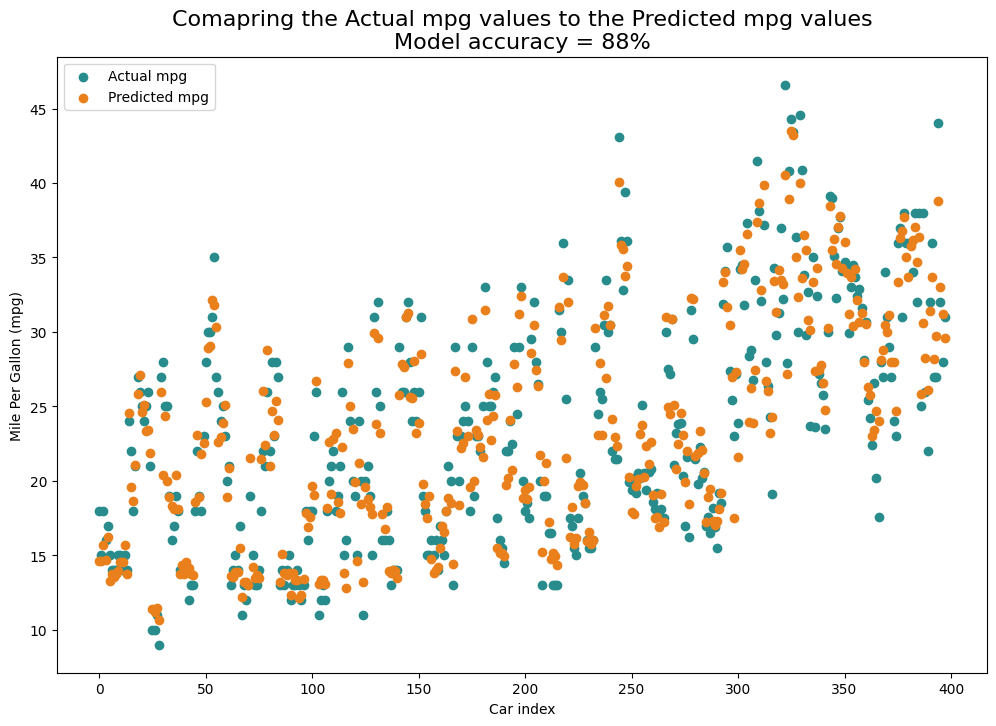

In [16]:
# Create a scatterplot comparing actual and predicted mpg values
dataP = data2.drop('mpg',axis=1)  # create a new DataFrame of the feature variables

# make a DataFrame of the actual mpg and the predicted mpg 
dataGraph = pd.DataFrame({'Actual mpg':data2.mpg.values,
                      'Predicted mpg':model_6.predict(dataP.values)})

# make a scatter plot of the actual and the predicted mpg of a car
plt.figure(figsize=(12,8))
plt.scatter(dataGraph.index,dataGraph['Actual mpg'].values, color='#298c8c', label='Actual mpg')
plt.scatter(dataGraph.index,dataGraph['Predicted mpg'].values, color='#ea801c', label='Predicted mpg')
plt.title('Comapring the Actual mpg values to the Predicted mpg values\nModel accuracy = 88%', fontsize=16)
plt.xlabel('Car index')
plt.ylabel('Mile Per Gallon (mpg)')
plt.legend(loc='upper left')
plt.show()